In [2]:
import os
from glob import glob
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from scipy.optimize import lsq_linear
from sklearn.linear_model import LinearRegression
import pickle
import seaborn as sns
from datetime import date

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%matplotlib inline 

In [5]:
import mplhep as hep
hep.style.use("CMS")
matplotlib.rcParams['figure.dpi'] = 100

In [6]:
tele = pd.read_csv('/ecoderemdvol/paper_plots/physics/tele.csv')
emd  = pd.read_csv('/ecoderemdvol/paper_plots/physics/emd.csv')

In [7]:
binetasize = 0.1
binptsize = 5

tele['genpart_bineta'] = ((tele.genpart_abseta - 1.6)/binetasize).astype('int32')
emd['genpart_bineta'] = ((emd.genpart_abseta - 1.6)/binetasize).astype('int32')

In [8]:
def effrms(df, c=0.68):
    """Compute half-width of the shortest interval
    containing a fraction 'c' of items in a 1D array.
    """
    out = {}
    for col in df:
        x = df[col]
        x = np.sort(x, kind="mergesort")
        m = int(c * len(x)) + 1
        out[col] = [np.min(x[m:] - x[:-m]) / 2.0]
    return pd.DataFrame(out).iloc[0]

In [9]:
eta_binned = {} 
pt_mean_binned = {} 
pt_rms_eff_binned={}
#For telescope_loss first

select = tele.query('genpart_pid==1 and genpart_pt>10')
eta_binned['AEtele'] = (select.groupby('genpart_bineta').mean())['genpart_abseta']
pt_mean_binned['AEtele'] = (select.groupby('genpart_bineta').mean())['corr_eta_over_gen_pt']
pt_rms_eff_binned['AEtele'] = (select.groupby('genpart_bineta').apply(effrms))['corr_eta_over_gen_pt']

#emd next

select = emd.query('genpart_pid==1 and genpart_pt>10')
eta_binned['AElphe'] = (select.groupby('genpart_bineta').mean())['genpart_abseta']
pt_mean_binned['AElphe'] = (select.groupby('genpart_bineta').mean())['corr_eta_over_gen_pt']
pt_rms_eff_binned['AElphe'] = (select.groupby('genpart_bineta').apply(effrms))['corr_eta_over_gen_pt']

Eff RMS vs eta


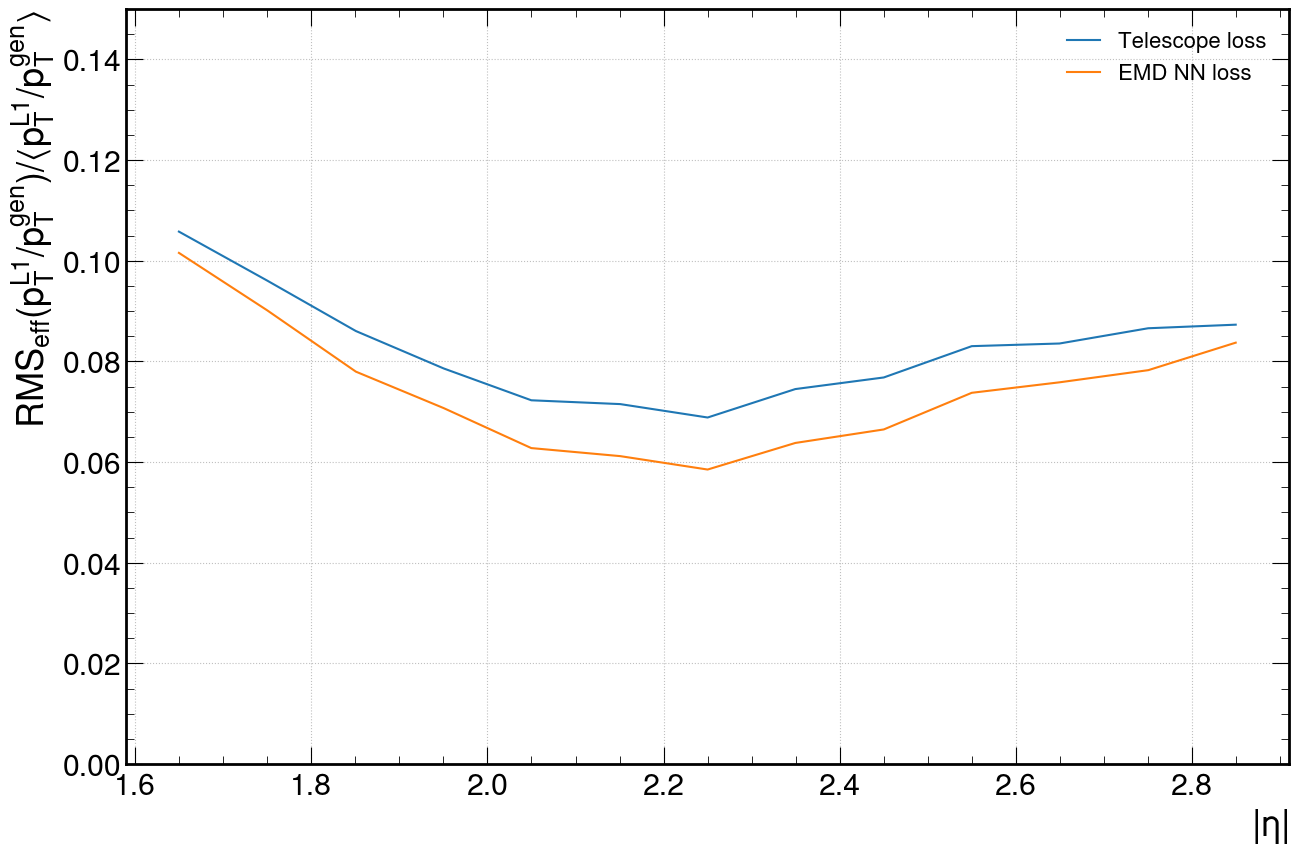

In [10]:
print('Eff RMS vs eta')
plt.figure(figsize=(15,10))
plt.plot(eta_binned['AEtele'], pt_rms_eff_binned['AEtele']/pt_mean_binned['AEtele'],label='Telescope loss')
plt.plot(eta_binned['AElphe'], pt_rms_eff_binned['AElphe']/pt_mean_binned['AElphe'],label='EMD NN loss')
plt.ylim(0,0.15)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()

In [11]:
eta = {} 
pt = {} 

#For telescope_loss first

select = tele.query('genpart_pid==1 and genpart_pt>10')
eta['AEtele'] = select['genpart_abseta'].values
pt['AEtele'] = select['corr_eta_over_gen_pt'].values

#emd next

select = emd.query('genpart_pid==1 and genpart_pt>10')
eta['AElphe'] = select['genpart_abseta'].values
pt['AElphe'] = select['corr_eta_over_gen_pt'].values

In [48]:
#full_jk = np.empty(shape=(len(eta['AElphe']),13))

In [ ]:
n = len(eta['AElphe'])


full_jk = np.empty(shape=(n,13))

for i in range(n):
    
    jk_eta = np.delete(eta['AElphe'],i)
    jk_pt = np.delete(pt['AElphe'],i)
    
    eta_binned = {} 
    pt_mean_binned = {} 
    pt_rms_eff_binned={}
    
    jk_bin_eta = ((jk_eta - 1.6)/0.1).astype('int32')
    
    df = pd.DataFrame(columns=['eta','bin_eta','pt'])
    
    df['eta'] = jk_eta
    df['bin_eta'] = jk_bin_eta
    df['pt'] = jk_pt

    eta_binned['AElphe'] = (df.groupby('bin_eta').mean())['eta']
    pt_mean_binned['AElphe'] = (df.groupby('bin_eta').mean())['pt']
    pt_rms_eff_binned['AElphe'] = (df.groupby('bin_eta').apply(effrms))['pt']
    
    physics_res = pt_rms_eff_binned['AElphe']/pt_mean_binned['AElphe']
    
    full_jk[i] = np.asarray(physics_res)

In [68]:
mean_binned = np.empty(shape=(13))
std_binned = np.empty(shape=(13))

In [69]:
for i in range(13):
    
    mean_binned[i] = (full_jk[:,i]).mean()
    std_binned[i] = (full_jk[:,i]).std()

In [74]:
std_binned

array([1.00023797e-06, 4.78887865e-06, 6.39339028e-06, 3.37032301e-06,
       4.03989877e-06, 4.47722547e-06, 4.10194448e-06, 1.48586813e-06,
       2.04345140e-06, 1.39456905e-06, 3.10937226e-06, 3.79311913e-06,
       4.62273736e-06])

(0.0, 0.2)

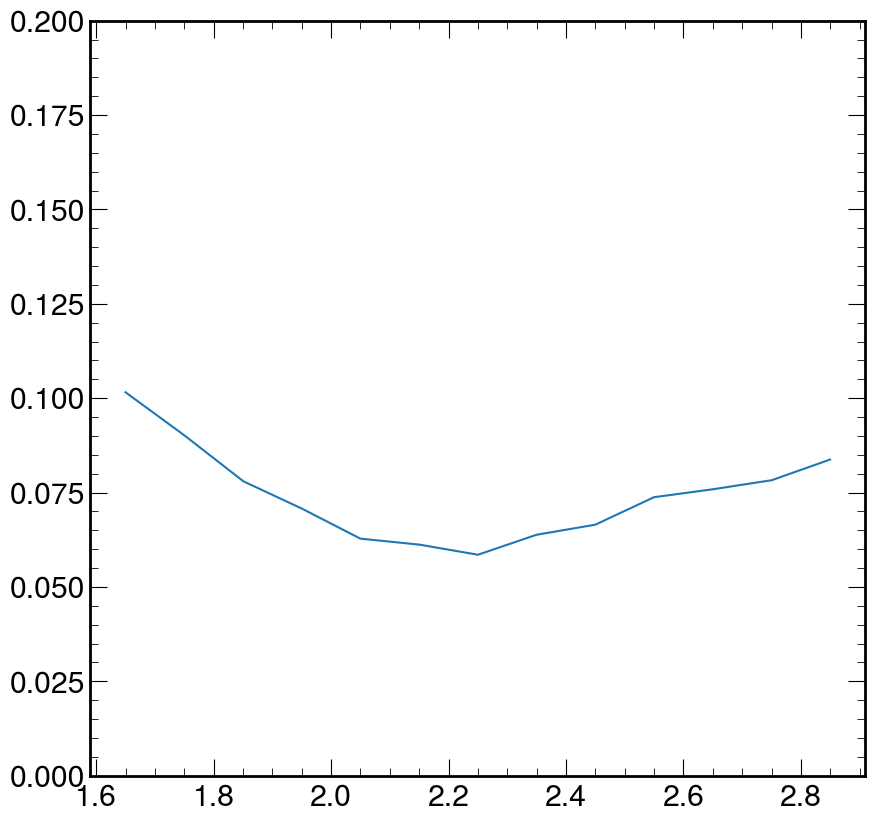

In [73]:
plt.errorbar(eta_binned['AElphe'],mean_binned,xerr=std_binned,ecolor='red')
plt.ylim(0,0.2)